<a href="https://colab.research.google.com/github/amsc101/ICU/blob/master/ICU_Mortality_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ICU Mortality Prediction

**NO utilizar mayúsculas** en nombres de variables porfa, gracias ~Ana

In [0]:
# Import libraries
import numpy as np
import matplotlib
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/training_v2.csv")

# Content
1. General info

  a) df visualisation
  
  b) drop variables with a lot of missing values
2. Remove outliers
3. Replace missing values
4. One Hot Encoding
5. Normalisation

  a) x, y and train_test_split

  b) standarisation

#General Info

In [0]:
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,...,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,...,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0.0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0.0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,30.0,30.0,142.0,7.39,...,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0.0,103.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [0]:
print('nº of variables : ', data.shape[1],'\nnº of patients: ', data.shape[0])

nº of variables :  186 
nº of patients:  91713


***Remove variables with a lot of missing values***



In [0]:
threshold = len(data) * 0.60
df_thresh=data.dropna(axis=1, thresh=threshold)
df_thresh.shape

(91713, 112)

In [0]:
print(df_thresh.shape)
display(df_thresh.nunique())

(91713, 112)


encounter_id                   91713
patient_id                     91713
hospital_id                      147
hospital_death                     2
age                               74
                               ...  
leukemia                           2
lymphoma                           2
solid_tumor_with_metastasis        2
apache_3j_bodysystem              11
apache_2_bodysystem               10
Length: 112, dtype: int64

In [0]:
df_thresh.drop(['encounter_id', 'patient_id', 'hospital_id', 'icu_id'], axis='columns', inplace=True)
df_thresh.shape, data.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((91713, 108), (91713, 186))

*   **df_thresh** = df con variables con menos missing values
*   **data** = df original

# Outliers or errors

DE LA 75 A LA 110
Index(['d1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min',
       'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'hospital_id', 'hospital_death',
       'elective_surgery', 'ethnicity', 'gender', 'hospital_admit_source',
       'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'readmission_status', 'apache_post_operative', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

**apache_4a_hospital_death_prob**: The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis

(-1.0, 0.99)

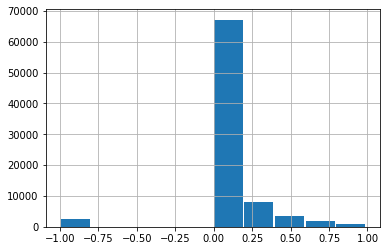

In [0]:
data['apache_4a_hospital_death_prob'].hist(rwidth=0.95)
min(data['apache_4a_hospital_death_prob']),max(data['apache_4a_hospital_death_prob'])

**Importante: quitar errores --> valores negativos**

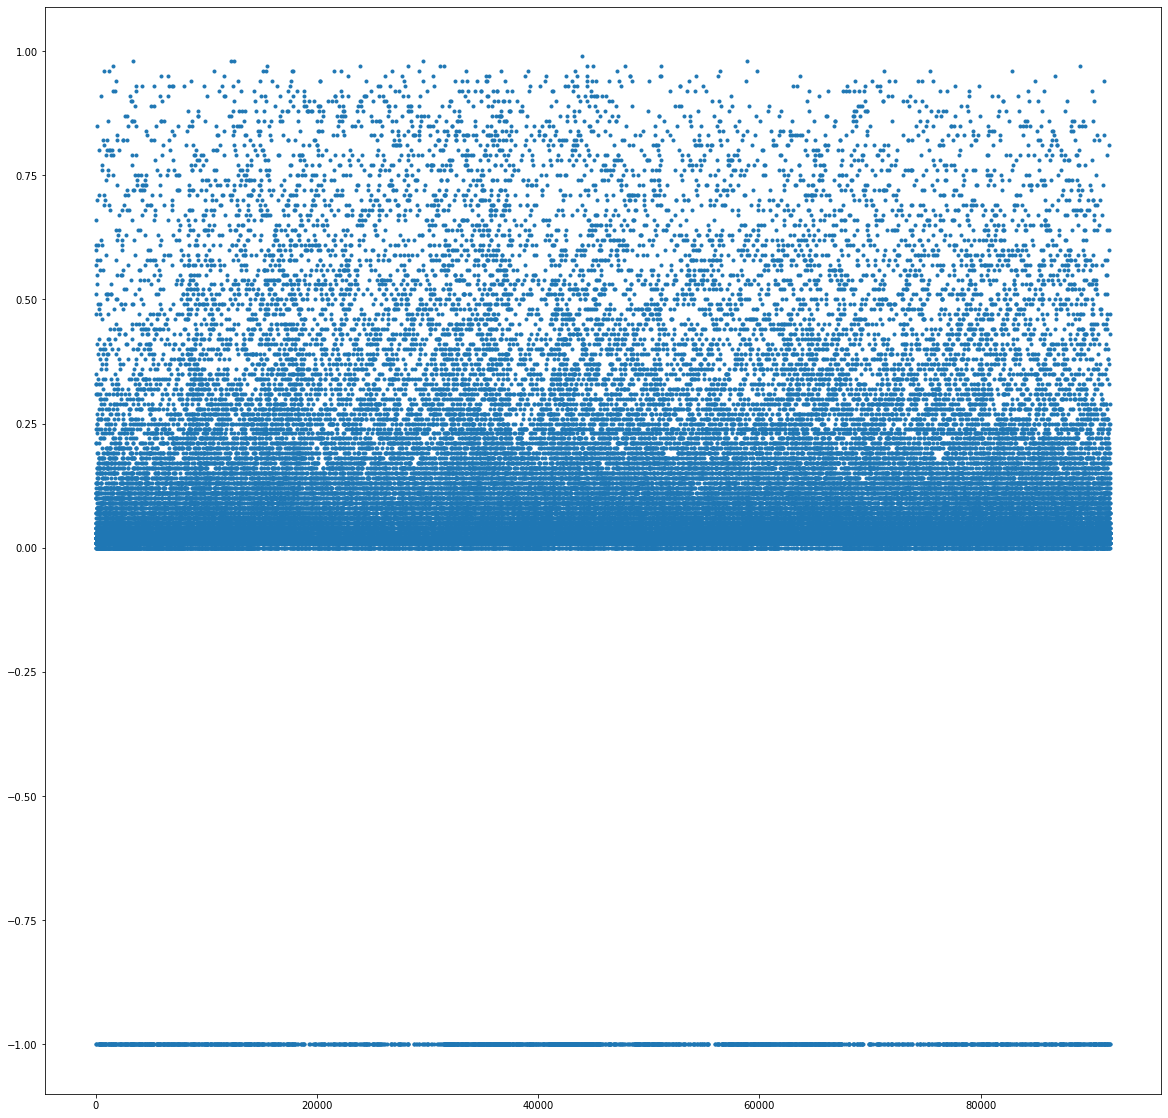

In [0]:
plt.figure(figsize=(20,20))
plt.plot(data['apache_4a_hospital_death_prob'],'.')
plt.show()

https://www.kaggle.com/c/widsdatathon2020/discussion/127698
Los valores negativos (imposibles: porque no existen probs negativas) pueden indiar que son missing values.

In [0]:
df_thresh['apache_4a_hospital_death_prob'].isna().sum()

7947

In [0]:
count = 0
for i in df_thresh['apache_4a_hospital_death_prob']:
  if i == -1:
    count += 1
print(count)


2371


In [0]:
df_thresh['apache_4a_hospital_death_prob'] = df_thresh['apache_4a_hospital_death_prob'].replace(-1, np.nan)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 0.99)

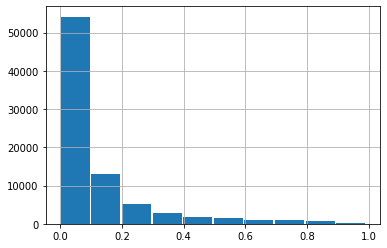

In [0]:
df_thresh['apache_4a_hospital_death_prob'].hist(rwidth=0.95)
min(df_thresh['apache_4a_hospital_death_prob']),max(df_thresh['apache_4a_hospital_death_prob'])

**apache_4a_icu_death_prob**: The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis

(-1.0, 0.97)

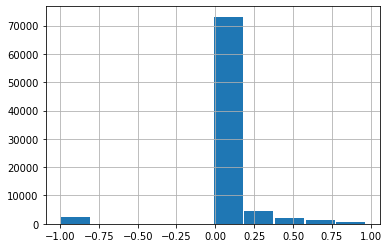

In [0]:
data['apache_4a_icu_death_prob'].hist(rwidth=0.95)
min(data['apache_4a_icu_death_prob']),max(data['apache_4a_icu_death_prob'])


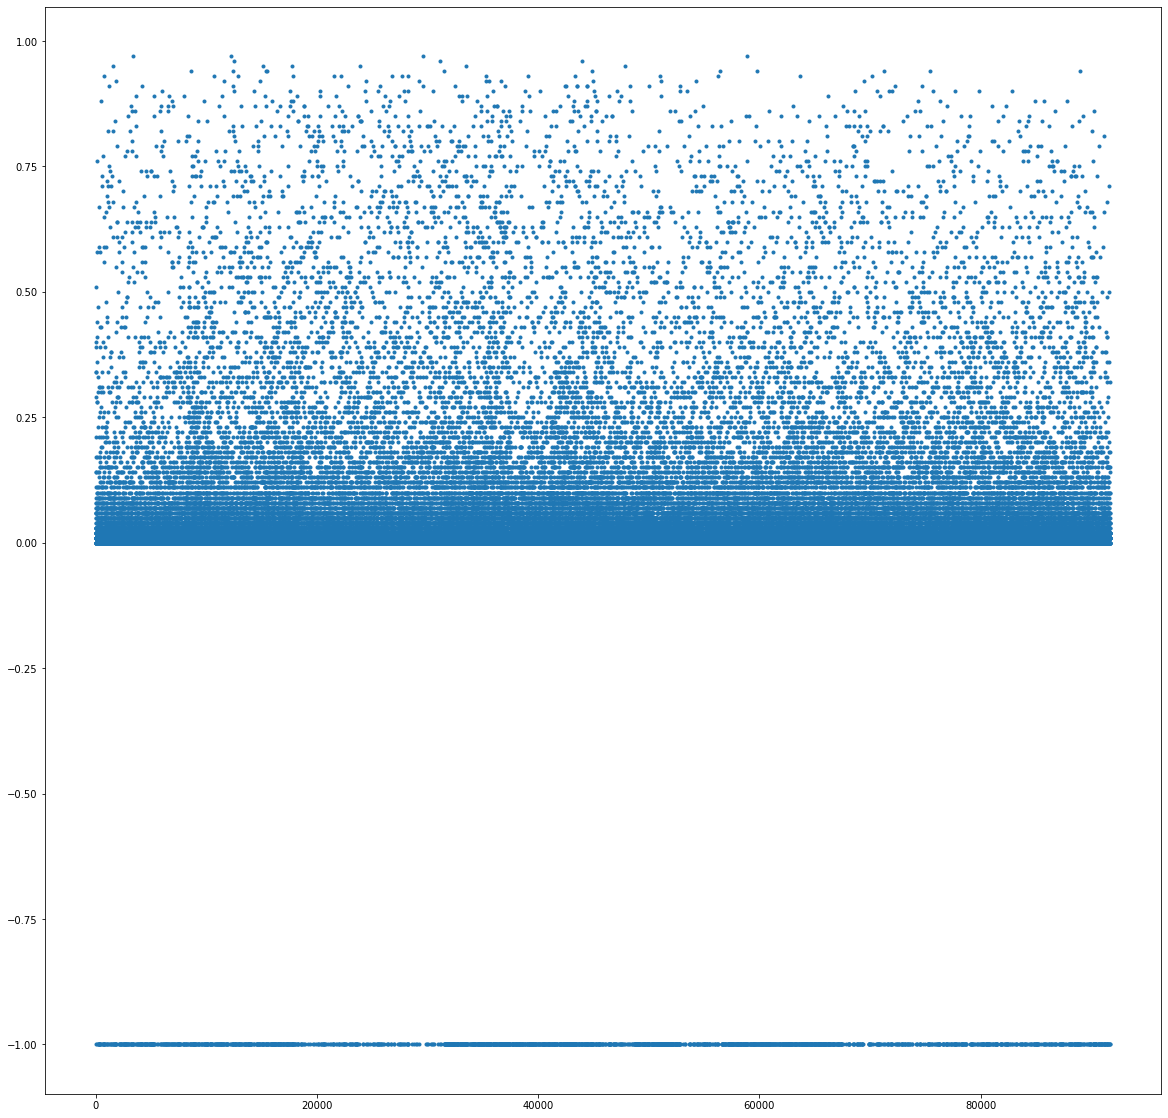

In [0]:
plt.figure(figsize=(20,20))
plt.plot(data['apache_4a_icu_death_prob'],'.')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 0.97)

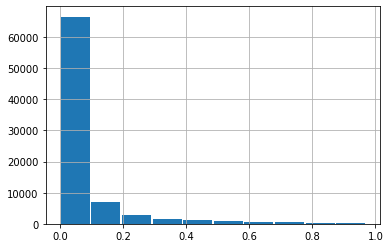

In [0]:
df_thresh['apache_4a_icu_death_prob'] = df_thresh['apache_4a_icu_death_prob'].replace(-1, np.nan)

df_thresh['apache_4a_icu_death_prob'].hist(rwidth=0.95)
min(df_thresh['apache_4a_icu_death_prob']),max(df_thresh['apache_4a_icu_death_prob'])

#Data type

In [0]:
col_name = list(df_thresh.columns)
col_type = list(df_thresh.dtypes)
print(list(zip(col_name, col_type)))

[('hospital_death', dtype('int64')), ('age', dtype('float64')), ('bmi', dtype('float64')), ('elective_surgery', dtype('int64')), ('ethnicity', dtype('O')), ('gender', dtype('O')), ('height', dtype('float64')), ('hospital_admit_source', dtype('O')), ('icu_admit_source', dtype('O')), ('icu_stay_type', dtype('O')), ('icu_type', dtype('O')), ('pre_icu_los_days', dtype('float64')), ('readmission_status', dtype('int64')), ('weight', dtype('float64')), ('apache_2_diagnosis', dtype('float64')), ('apache_3j_diagnosis', dtype('float64')), ('apache_post_operative', dtype('int64')), ('arf_apache', dtype('float64')), ('bun_apache', dtype('float64')), ('creatinine_apache', dtype('float64')), ('gcs_eyes_apache', dtype('float64')), ('gcs_motor_apache', dtype('float64')), ('gcs_unable_apache', dtype('float64')), ('gcs_verbal_apache', dtype('float64')), ('glucose_apache', dtype('float64')), ('heart_rate_apache', dtype('float64')), ('hematocrit_apache', dtype('float64')), ('intubated_apache', dtype('floa

**Categorical data**

In [0]:
categorical_cols = df_thresh.select_dtypes(exclude=['float', 'int']).columns
categorical_cols

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')

In [0]:
categorical_df = df_thresh[categorical_cols]
categorical_df

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma
...,...,...,...,...,...,...,...,...
91708,Caucasian,M,Acute Care/Floor,Floor,admit,Cardiac ICU,Sepsis,Cardiovascular
91709,Caucasian,F,Emergency Department,Floor,admit,Med-Surg ICU,Sepsis,Cardiovascular
91710,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
91711,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Respiratory,Respiratory


In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
categorical_df = imp.fit_transform(categorical_df)

In [0]:
categorical_df = pd.DataFrame(categorical_df)
categorical_df.columns = categorical_cols
categorical_df.isna().sum().sum()

0

**Numerical data**

In [0]:
numerical_cols = df_thresh.select_dtypes(include=['float', 'int']).columns
numerical_cols

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height',
       'pre_icu_los_days', 'readmission_status', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative',
       'arf_apache', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1

In [0]:
#numerical_df = df_thresh[np.array(numerical_cols)]
numerical_df = df_thresh[numerical_cols]
numerical_df

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,...,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,68.0,22.730000,0,180.3,0.541667,0,73.9,113.0,502.01,0,0.0,31.0,2.51,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,36.0,134.0,39.3,0.0,14.10,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,...,100.0,74.0,131.0,115.0,131.0,115.0,39.5,37.5,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.10,14.10,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,77.0,27.420000,0,160.0,0.927778,0,70.2,108.0,203.01,0,0.0,9.0,0.56,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,33.0,145.0,35.1,1.0,12.70,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,...,95.0,70.0,95.0,71.0,95.0,71.0,36.3,36.3,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.30,12.70,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,25.0,31.950000,0,172.7,0.000694,0,95.3,122.0,703.03,0,0.0,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,37.0,NaN,36.7,0.0,NaN,88.0,48.0,88.0,48.0,96.0,68.0,102.0,68.0,102.0,68.0,21.0,8.0,...,98.0,91.0,148.0,124.0,148.0,124.0,36.7,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,81.0,22.640000,1,165.1,0.000694,0,61.7,203.0,1206.03,1,0.0,NaN,NaN,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,4.0,NaN,34.8,1.0,8.00,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,...,100.0,99.0,136.0,106.0,NaN,NaN,35.6,34.8,NaN,NaN,NaN,NaN,NaN,NaN,185.0,88.0,NaN,NaN,11.6,8.9,34.0,25.9,198.0,43.0,5.0,3.5,NaN,NaN,9.00,8.00,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,19.0,NaN,0,188.0,0.073611,0,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0.0,103.0,16.0,NaN,36.7,0.0,NaN,99.0,57.0,99.0,57.0,89.0,60.0,104.0,90.0,104.0,90.0,18.0,16.0,...,100.0,100.0,130.0,120.0,130.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0,75.0,23.060250,0,177.8,0.298611,0,72.9,113.0,501.06,0,0.0,NaN,NaN,4.0,6.0,0.0,5.0,381.0,115.0,NaN,0.0,48.0,9.0,NaN,36.6,1.0,NaN,104.0,44.0,104.0,44.0,115.0,70.0,109.0,48.0,109.0,48.0,27.0,9.0,...,98.0,97.0,94.0,87.0,94.0,87.0,38.2,38.2,27.0,27.0,8.2,8.2,1.10,1.10,400.0,187.0,28.0,28.0,13.2,13.2,39.0,39.0,92.0,92.0,4.2,4.2,140.0,140.0,5.68,5.68,0.12,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
91709,0,56.0,47.179671,0,183.0,0.120139,0,158.0,113.0,501.05,0,0.0,34.0,2.30,4.0,6.0,0.0,5.0,177.0,100.0,

In [0]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
numerical_df = imp.fit_transform(numerical_df)

In [0]:
numerical_df = pd.DataFrame(numerical_df)
numerical_df.columns = numerical_cols
numerical_df.isna().sum().sum()

0

# One Hot Encoding

In [0]:
categorical_df.head(10)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem
0,Caucasian,M,Floor,Floor,admit,CTICU,Sepsis,Cardiovascular
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,Respiratory,Respiratory
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Metabolic,Metabolic
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,Cardiovascular,Cardiovascular
4,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Trauma,Trauma
5,Caucasian,M,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,Neurological,Neurologic
6,Caucasian,F,Operating Room,Accident & Emergency,admit,Med-Surg ICU,Respiratory,Respiratory
7,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Sepsis,Cardiovascular
8,Caucasian,M,Other Hospital,Other Hospital,admit,CCU-CTICU,Cardiovascular,Cardiovascular
9,Caucasian,M,Direct Admit,Accident & Emergency,admit,CCU-CTICU,Cardiovascular,Cardiovascular


In [0]:
ohe = []
for i in categorical_cols:
  ohe.append(pd.get_dummies(categorical_df[i], prefix = i))

In [0]:
for i in ohe:
  clean_data = pd.concat([numerical_df, i], axis=1)

In [0]:
clean_data.columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height',
       'pre_icu_los_days', 'readmission_status', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis',
       ...
       'apache_2_bodysystem_Cardiovascular',
       'apache_2_bodysystem_Gastrointestinal',
       'apache_2_bodysystem_Haematologic', 'apache_2_bodysystem_Metabolic',
       'apache_2_bodysystem_Neurologic',
       'apache_2_bodysystem_Renal/Genitourinary',
       'apache_2_bodysystem_Respiratory', 'apache_2_bodysystem_Trauma',
       'apache_2_bodysystem_Undefined Diagnoses',
       'apache_2_bodysystem_Undefined diagnoses'],
      dtype='object', length=110)

# Train and Test

In [0]:
y = clean_data['hospital_death']
x = clean_data.loc[:, clean_data.columns != 'hospital_death']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [0]:
names = x_train.columns

scaler = preprocessing.StandardScaler()

x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=names)

In [0]:
x_train

,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,1.248125,0.226357,-0.473131,-1.133799,-0.322662,0.0,-0.311165,-0.860210,-0.982706,-0.500043,-0.167358,1.195288,-0.172416,-0.50682,0.404291,-0.096433,0.634037,-0.302745,-1.290962,-1.022260,-0.420073,1.060754,1.149883,-0.884930,-0.138181,1.447771,-0.565965,-0.127163,-0.764401,-0.132171,-0.772533,-1.088784,-0.599481,1.313713,0.199053,1.335789,0.199825,3.101863,-0.362994,0.414398,...,0.446978,-0.016181,-0.077677,-0.160079,-0.474007,0.291135,1.673269,0.587083,-1.074444,-0.954800,-0.532927,-0.981089,-1.394927,-1.299616,3.258357,3.227164,0.194818,-0.830738,-1.414212,-1.359877,0.212914,0.036638,-0.029082,-0.12763,-0.535230,-0.115688,-0.16212,-0.082584,-0.06332,-0.144222,1.120379,-0.330753,-0.081828,-0.300915,-0.384618,-0.165063,-0.380850,-0.20986,-0.059864,-0.205396
1,-0.214229,3.172252,-0.473131,1.708136,-0.329644,0.0,4.123414,1.438038,0.316190,-0.500043,-0.167358,-0.634761,-0.431694,0.55362,0.404291,-0.096433,0.634037,1.841760,-2.169180,0.884342,-0.420073,-0.491712,-1.364242,-0.673515,-0.383167,-0.690717,-0.684299,-0.177733,1.565713,-0.182987,1.564658,-1.179659,-0.833259,-0.272949,1.348349,-0.267912,1.354400,-1.206910,-0.362994,-0.679895,...,1.034876,0.258661,-0.397817,-0.443764,1.680098,2.719253,0.172496,-0.288445,0.947477,1.095575,0.685861,0.811053,-0.843844,-0.738503,0.431090,-0.056810,-0.465818,-0.616343,-0.868575,-0.744814,-0.412761,-0.356051,-0.029082,-0.12763,-0.535230,-0.115688,-0.16212,-0.082584,-0.06332,-0.144222,-0.892555,-0.330753,-0.081828,3.323201,-0.384618,-0.165063,-0.380850,-0.20986,-0.059864,-0.205396
2,1.491851,-0.718250,2.113578,-0.303424,-0.167370,0.0,-0.858942,1.391373,1.625987,1.999830,-0.167358,1.038427,-0.208426,0.55362,0.404291,-0.096433,0.634037,0.792322,-1.323489,-0.512737,2.380540,-0.754437,-1.099598,-1.096346,-0.015688,1.447771,-0.423965,-0.430578,-1.440886,-0.437065,-1.451072,-1.225096,-1.183925,-0.994159,-1.077944,-0.996867,-1.083035,-0.457558,-1.942573,0.414398,...,0.153028,0.121240,-0.251666,-0.270401,0.597160,1.181445,0.172496,-0.069563,-0.433347,-0.499161,-0.326935,-0.502154,1.444353,1.359572,1.059371,1.767620,-0.686030,-1.045134,-0.196412,-0.450654,0.275481,-0.120438,-0.029082,-0.12763,1.868357,-0.115688,-0.16212,-0.082584,-0.06332,-0.144222,-0.892555,-0.330753,-0.081828,-0.300915,-0.384618,-0.165063,2.625708,-0.20986,-0.059864,-0.205396
3,0.212291,2.634088,-0.473131,-1.609632,0.591770,0.0,1.424806,-0.953540,-0.760784,-0.500043,-0.167358,0.567843,0.691844,-0.50682,0.404291,-0.096433,-0.011320,-1.021382,0.140208,0.128276,-0.420073,-1.112698,-1.430404,-0.250683,0.106806,1.447